In [130]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import warnings

import pandas as pd
import numpy as np 
import optuna

import boto3
import pymysql
import sagemaker
from sagemaker.sklearn.estimator import SKLearn
from sagemaker.sklearn.model import SKLearnModel
from sagemaker.tuner import HyperparameterTuner
from tqdm import tqdm
from hydra import compose, initialize, core
from omegaconf import OmegaConf
from sklearn.metrics import classification_report, PrecisionRecallDisplay
from sklearn.calibration import CalibrationDisplay, calibration_curve

import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(os.path.dirname(os.getcwd()))
from src.custom_utils import get_secret, get_db_url, StudyVisualizer

In [99]:
warnings.filterwarnings('ignore')

## Hydra

In [88]:
core.global_hydra.GlobalHydra.instance().clear()
initialize(version_base='1.2', config_path='../src/config', job_name='modeling')
config = OmegaConf.to_container(compose(config_name='main'), resolve=True)

## S3

In [3]:
s3 = boto3.client('s3')

s3_check_point = f's3://{config["s3_bucket"]}/{config["s3_key"]}/checkpoint'

train_channel = {'train': sagemaker.inputs.TrainingInput(
    s3_data=f's3://{config["s3_bucket"]}/{config["s3_key"]}/input-data/train/',
    distribution='FullyReplicated',
    content_type='text/csv',
    s3_data_type='S3Prefix',
    input_mode='File'
)}

train_channel

{'train': <sagemaker.inputs.TrainingInput at 0x7f576ce22da0>}

## SageMaker

In [4]:
sagemaker_session = sagemaker.Session(default_bucket=config['s3_bucket'])
sm_boto3 = boto3.client('sagemaker')
role = sagemaker.get_execution_role()

## Database Setup

In [5]:
cf = boto3.client('cloudformation')
outputs = cf.describe_stacks(StackName=config.stack_name)['Stacks'][0]['Outputs']

# 'Outputs' is a list of dictionaries, and we extract specific outputs based on their OutputKey property
host = [out['OutputValue'] for out in outputs if out['OutputKey'] == 'ClusterEndpoint'][0].split(':')[0]
db_name = [out['OutputValue'] for out in outputs if out['OutputKey'] == 'DatabaseName'][0]
secret_name = [out['OutputValue'] for out in outputs if out['OutputKey'] == 'DBSecretArn'][0].split(':')[-1].split('-')[0]

subnets = [out['OutputValue'] for out in outputs if out['OutputKey'] == 'PrivateSubnets'][0].split(',')
security_group_ids = [out['OutputValue'] for out in outputs if out['OutputKey'] == 'SageMakerSecurityGroup'][0].split(',')

## XGBoost

Test locally:

In [53]:
test_study_name = 'test_study'

test_estimator = SKLearn(
    # Sagemaker
    entry_point=config['xgboost']['entry_point'],
    framework_version=config['framework_version'],
    py_version=config['py_version'],
    source_dir=config['src_dir_path'],
    role=role,
    instance_type='local',
    instance_count=config['xgboost']['instance_count'],
    output_path=config['output_path'],
    code_location=config['code_location'],
    # Optuna 
    subnets=subnets,
    security_group_ids=security_group_ids,
    hyperparameters={
        'host': host, 
        'db_name': db_name, 
        'study_name': test_study_name,
        'db_secret': secret_name, 
        'region_name': sagemaker_session._region_name,
        'n_trials': 2,
        'test_mode': 1
    }
)
test_estimator

In [54]:
!sudo rm -rf /tmp/tmp*

In [60]:
test_estimator.fit(train_channel)

INFO:sagemaker:Creating training-job with name: sagemaker-scikit-learn-2023-06-26-04-05-01-775
INFO:sagemaker.local.local_session:Starting training job
INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole
INFO:sagemaker.local.image:No AWS credentials found in session but credentials from EC2 Metadata Service are available.
INFO:sagemaker.local.image:docker compose file: 
networks:
  sagemaker-local:
    name: sagemaker-local
services:
  algo-1-kv10o:
    command: train
    container_name: 8nr0ett7vl-algo-1-kv10o
    environment:
    - '[Masked]'
    - '[Masked]'
    image: 683313688378.dkr.ecr.us-east-1.amazonaws.com/sagemaker-scikit-learn:1.2-1-cpu-py3
    networks:
      sagemaker-local:
        aliases:
        - algo-1-kv10o
    stdin_open: true
    tty: true
    volumes:
    - /tmp/tmpbzxkt4sq/algo-1-kv10o/output:/opt/ml/output
    - /tmp/tmpbzxkt4sq/algo-1-kv10o/input:/opt/ml/input
    - /tmp/tmpbzxkt4sq/algo-1-kv10o/output/data:/opt/ml/o

Creating 8nr0ett7vl-algo-1-kv10o ... 
Creating 8nr0ett7vl-algo-1-kv10o ... done
Attaching to 8nr0ett7vl-algo-1-kv10o
8nr0ett7vl-algo-1-kv10o | 2023-06-26 04:05:04,398 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
8nr0ett7vl-algo-1-kv10o | 2023-06-26 04:05:04,403 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
8nr0ett7vl-algo-1-kv10o | 2023-06-26 04:05:04,411 sagemaker_sklearn_container.training INFO     Invoking user training script.
8nr0ett7vl-algo-1-kv10o | 2023-06-26 04:05:04,655 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
8nr0ett7vl-algo-1-kv10o | /miniconda3/bin/python -m pip install -r requirements.txt
8nr0ett7vl-algo-1-kv10o | Collecting optuna==3.1.0 (from -r requirements.txt (line 1))
8nr0ett7vl-algo-1-kv10o |   Downloading optuna-3.1.0-py3-none-any.whl (365 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 kB 32.0 MB/s eta 0:00:0031m? eta -:--:--
8nr0ett

INFO:root:creating /tmp/tmpbzxkt4sq/artifacts/output/data
INFO:root:copying /tmp/tmpbzxkt4sq/algo-1-kv10o/output/success -> /tmp/tmpbzxkt4sq/artifacts/output
INFO:root:copying /tmp/tmpbzxkt4sq/model/best-model.joblib -> /tmp/tmpbzxkt4sq/artifacts/model


8nr0ett7vl-algo-1-kv10o exited with code 0
Aborting on container exit...
===== Job Complete =====


In [61]:
db_url = get_db_url(host=host, db_name=db_name, db_secret=secret_name, region_name=sagemaker_session._region_name)

optuna.study.delete_study(study_name=test_study_name, storage=db_url)

INFO:botocore.credentials:Found credentials from IAM Role: BaseNotebookInstanceEc2InstanceRole


Re-instantiate estimator:

In [112]:
xgb_estimator = SKLearn(
    # Entry point and framework
    entry_point=config['xgboost']['entry_point'],
    base_job_name=config['xgboost']['base_job_name'],
    framework_version=config['framework_version'],
    py_version=config['py_version'],
    source_dir=config['src_dir_path'],
    # Sagemaker
    role=role,
    instance_type=config['xgboost']['instance_type'],
    instance_count=config['xgboost']['instance_count'],
    volume_size=config['volume_size'],
    output_path=config['output_path'],
    model_dir=config['model_dir'],
    code_location=config['code_location'],
    sagemaker_session=sagemaker_session,
    # Spot training
    use_spot_instances=config['use_spot_instances'],
    max_retry_attempts=config['max_retry_attempts'],
    max_run=config['max_run'],
    max_wait=config['max_run'], # This should be equal to or greater than max_run
    checkpoint_s3_uri=s3_check_point + '/xgboost',
    # Optuna 
    subnets=subnets,
    security_group_ids=security_group_ids,
    hyperparameters={
        'host': host, 
        'db_name': db_name, 
        'db_secret': secret_name, 
        'study_name': config['xgboost']['study_name'],
        'region_name': sagemaker_session._region_name, 
        'n_trials': 100,
        'test_mode': 0
    }
)
xgb_estimator

### Hyperparameter Tuning

In [113]:
xgb_estimator.fit(train_channel)

INFO:sagemaker:Creating training-job with name: xgboost-training-2023-06-26-05-40-16-202


Using provided s3_resource
2023-06-26 05:40:16 Starting - Starting the training job...
2023-06-26 05:40:31 Starting - Preparing the instances for training......
2023-06-26 05:41:29 Downloading - Downloading input data...
2023-06-26 05:42:05 Training - Training image download completed. Training in progress...2023-06-26 05:42:21,906 sagemaker-containers INFO     Imported framework sagemaker_sklearn_container.training
2023-06-26 05:42:21,909 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-06-26 05:42:21,917 sagemaker_sklearn_container.training INFO     Invoking user training script.
2023-06-26 05:42:22,122 sagemaker-training-toolkit INFO     Installing dependencies from requirements.txt:
/miniconda3/bin/python -m pip install -r requirements.txt
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 kB 35.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 

### Visualize HPO Results

In [114]:
study = optuna.study.load_study(study_name=config.xgboost.study_name, storage=db_url)
study

In [115]:
hpo_visualizer = StudyVisualizer(study=study)
hpo_visualizer

History plot:

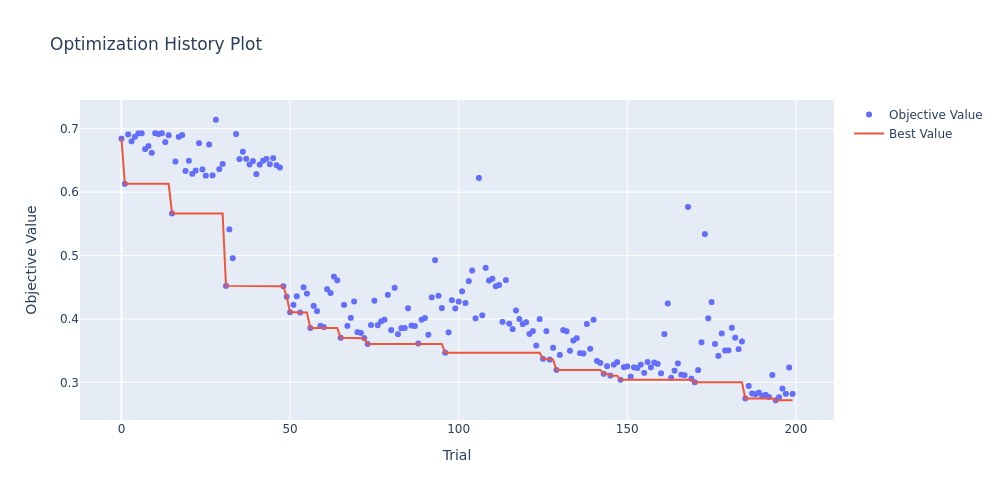

In [116]:
hpo_visualizer.plot_optimization_history(figsize=(1000, 500))

Parallel coordinates:

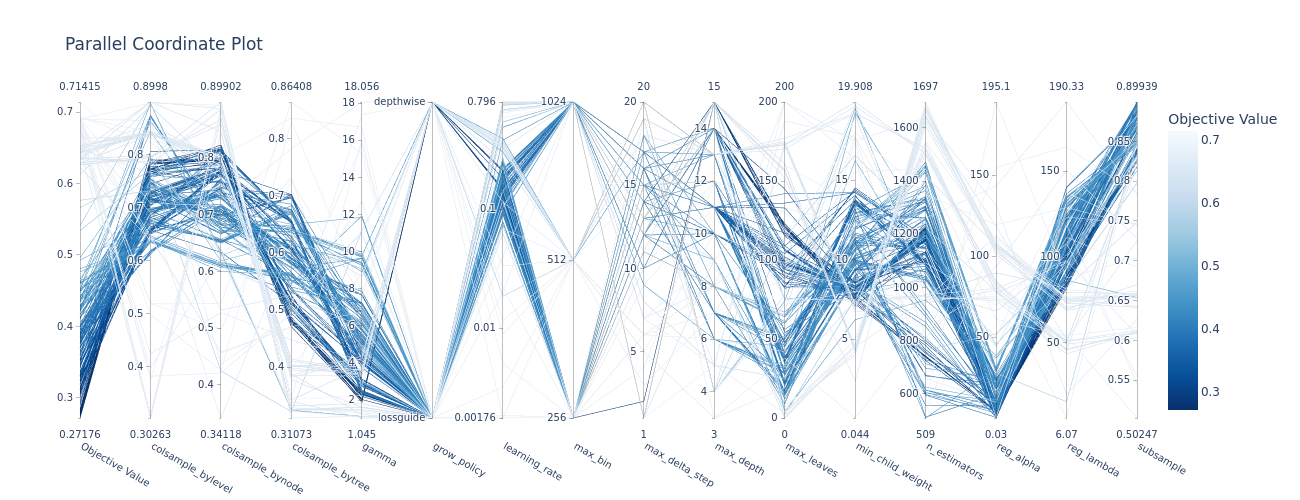

In [117]:
hpo_visualizer.plot_parallel_coordinate(
    figsize=(1300, 500), 
    params=['n_estimators', 'max_depth', 'learning_rate', 'gamma', 'max_delta_step', 'min_child_weight', 'max_leaves', 'subsample', 
            'colsample_bytree', 'colsample_bylevel', 'colsample_bynode', 'reg_alpha', 'reg_lambda', 'max_bin', 'grow_policy']
)

Importance plot:

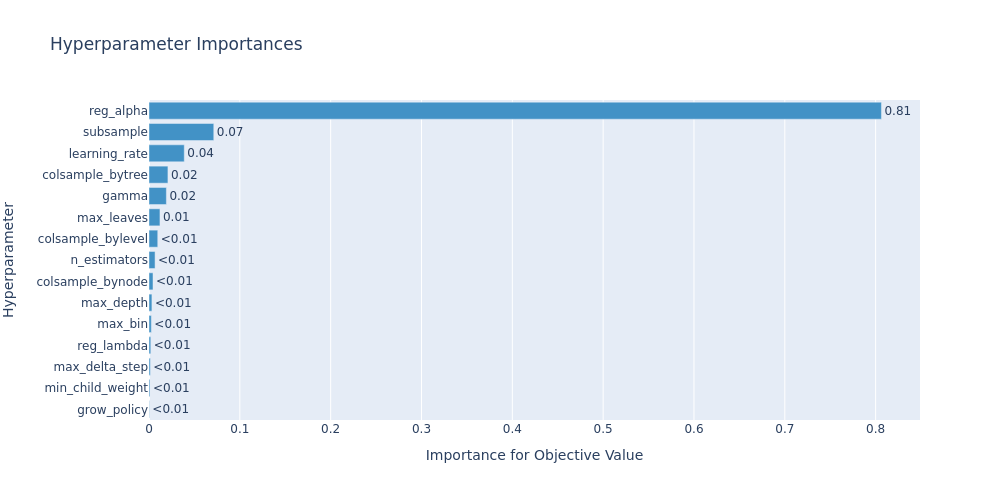

In [118]:
hpo_visualizer.plot_param_importances(figsize=(1000, 500))

## Inference

In [127]:
best_model_s3_path = sm_boto3.describe_training_job(
    TrainingJobName=study.best_trial.user_attrs['job_name']
)['ModelArtifacts']['S3ModelArtifacts']

print(f'Best model artifacts persisted at {best_model_s3_path}')

Best model artifacts persisted at s3://yang-ml-sagemaker/icr-classification/model/xgboost-training-2023-06-26-05-40-16-202/output/model.tar.gz


In [129]:
predictor = xgb_estimator.deploy(
    initial_instance_count=config['xgboost']['instance_count'],
    instance_type=config['xgboost']['instance_type'],
    endpoint_name=config['xgboost']['endpoint_name']
)

INFO:sagemaker:Creating model with name: xgboost-training-2023-06-26-06-26-05-949
INFO:sagemaker:Creating endpoint-config with name xgboost-endpoint-v1
INFO:sagemaker:Creating endpoint with name xgboost-endpoint-v1


----!

Training set:

In [131]:
data = pd.read_csv(f's3://{config["s3_bucket"]}/{config["s3_key"]}/input-data/train/train.csv')
X, y = data.reset_index(drop=True).drop(['Class', 'Id'], axis=1), data['Class']
X.shape, y.shape

((617, 56), (617,))

Predictions on training set:

In [135]:
y_pred = predictor.predict(X)
y_pred

array([[0.01873511, 0.9812649 ],
       [0.9765691 , 0.02343088],
       [0.8165351 , 0.18346491],
       ...,
       [0.965962  , 0.03403802],
       [0.9098796 , 0.0901204 ],
       [0.9122891 , 0.08771089]], dtype=float32)

Evaluation:

In [136]:
print(classification_report(
    y,
    y_pred.argmax(axis=1)
))

              precision    recall  f1-score   support

           0       1.00      0.89      0.94       509
           1       0.66      1.00      0.79       108

    accuracy                           0.91       617
   macro avg       0.83      0.94      0.87       617
weighted avg       0.94      0.91      0.92       617



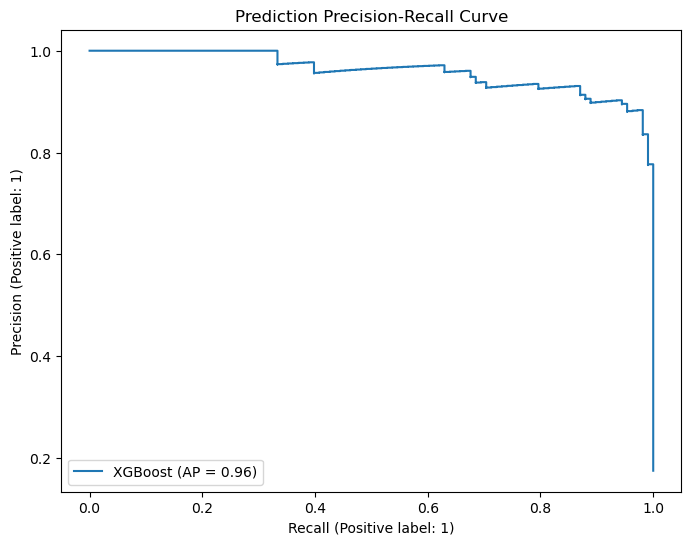

In [143]:
fig, ax = plt.subplots(figsize=(8, 6))
PrecisionRecallDisplay.from_predictions(y, y_pred[:, 1], name='XGBoost', ax=ax)
plt.title('Prediction Precision-Recall Curve')
plt.show();

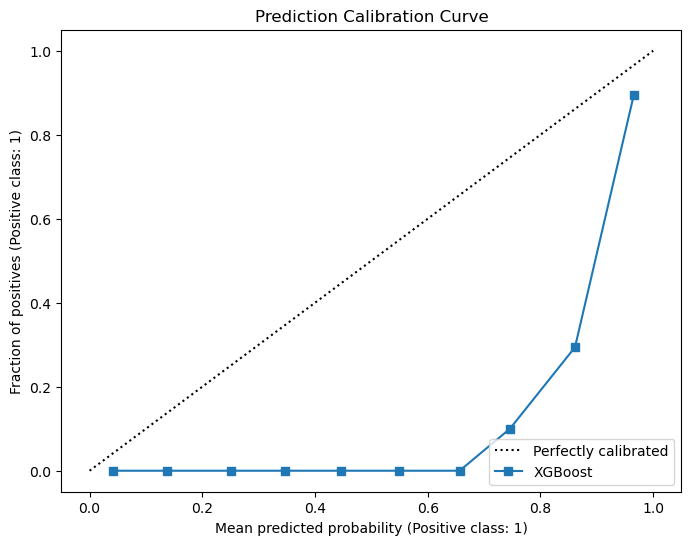

In [142]:
fig, ax = plt.subplots(figsize=(8, 6))
CalibrationDisplay.from_predictions(y, y_pred[:, 1], n_bins=10, name='XGBoost', ax=ax)
plt.title('Prediction Calibration Curve')
plt.show();

## Clean-up

In [155]:
sm_boto3.delete_endpoint(EndpointName=predictor.endpoint_name)
sm_boto3.delete_endpoint_config(EndpointConfigName=predictor.endpoint_name)
sm_boto3.delete_model(ModelName=predictor._get_model_names()[0])

{'ResponseMetadata': {'RequestId': '21e68500-6ad4-4bca-a00a-2711b15d54fa',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': '21e68500-6ad4-4bca-a00a-2711b15d54fa',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '0',
   'date': 'Mon, 26 Jun 2023 06:33:36 GMT'},
  'RetryAttempts': 0}}

In [156]:
sm_boto3.close()